![](https://img.shields.io/badge/PO.DAAC-Contribution-%20?color=grey&labelColor=blue)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/DataStories/eof_example_ersst.ipynb). 

# EOF decomposition of global monthly SST data using the xeofs package

#### *Author: Dean Henze, NASA JPL PO.DAAC*

## Summary
This demo replicates part of an empirical orthogonal function (EOF) analysis on century-long, global sea surface temperatures (SSTs) published in Journal of Climate (Messie and Chavez, 2011): https://doi.org/10.1175/2011JCLI3941.1, and can be run entirely in the cloud. In this analysis, the first 6 EOF modes of global SST are investigated once signals from long term warming and the seasonal cycle are removed. 

The EOFs are computed on Smith and Reynolds Extended Reconstructed SST dataset in netCDF4 format (available on NASA's PO.DAAC, https://doi.org/10.5067/ERSST-L4N50), which provides monthly mean SST data gridded over the globe between 65 degrees N/S at 2 degree x 2 degree resolution. A subset of the data are taken for the period 1910 to 2008. As in Messie and Chavez (2011), the first 6 EOF's and principal components (PC's) are plotted (their Figures 4 and 5 respectively). We also reproduce their global map of SST variance at each gridpoint (their Fig. 2a).

Data are accessed using the `earthaccess` package, then loaded and preprocessed (e.g. linear trend and seasonal cycle removed) using `Xarray` built in functions. The EOF decomposition uses the `xeofs` package (https://xeofs.readthedocs.io/en/latest/).

## Requirements

### i. Compute Environment 
This tutorial can be run in the following environments:
- **AWS instance running in us-west-2**: NASA Earthdata Cloud data in S3 can be directly accessed via temporary credentials; this access is limited to requests made within the US West (Oregon) (code: `us-west-2`) AWS region.
- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine. However, accessing and loading >1000 files into local memory will take a long time, in comparison to running this notebook from AWS.

### ii. Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

### iii. Additional Requirements 
* It is recommended that you have some basic familiarity with the `Xarray` package in Python. 

## Learning objectives
* Replicate results from published researched fully in the cloud.
* Use a data access workflow with the `earthaccess` package that can be used both locally and in the cloud. 
* Load and preprocess (e.g. linear trend and seasonal cycle removed) using `Xarray` built in functions.
* Perform an EOF decomposition using the `xeofs` package.

## Additional References
* This reference was used as inspiration for implementing the analysis in Python: https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex18-EOF%20analysis%20global%20SST.ipynb
* Github issue with information on scaling the output from the xeofs package in different ways (for example the scale of the initial EOF and PC output by `xeofs` do not match those of the publication, but could be recomputed to do so): https://github.com/nicrie/xeofs/issues/81 

## Import Packages
In addition to the packages imported below, the following are also needed:
* The `cftime` package is required to decode the dataset's timestamps using `Xarray`.
* The `h5netcdf` package should be installed as a backend for `Xarray` to open the data.

In [1]:
## Version numbers listed next to each package:

# Data location and access packages:
import earthaccess                                 # 0.6.1

# Analysis packages:
import xarray as xr                                # 2023.9.0
import numpy as np                                 # 1.26.0
import xeofs as xe                                 # 1.1.0

# Visualization packages:
import matplotlib.pyplot as plt                    # 3.8.0
from cartopy.crs import EqualEarth, PlateCarree    # 0.22.0

%matplotlib inline


libgomp: Invalid value for environment variable OMP_NUM_THREADS


# 1. Authenticate EDL, locate SST data files, and load data

## 1.1 Authenticate

In [2]:
earthaccess.login() # Login with your credentials

## 1.2 Locate data files
The `earthaccess` package is used to login to locate file path endpoints and wrap them in "file-like objects" readable by `Xarray`, without downloading the files.

Although the above study uses the time period 1910 to 2009, we instead use 1910 to 2008, since the data providers of the dataset changed the time format from 2008 onward and xarray doesn't like trying to concatinate data files with different time formats.

In [3]:
# Locate data file information, which includes endpoints, on Earthdata Cloud:
datainfo = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2008-02-01"), # We only want till end of 2007, but this ending date was required to obtain that.
    )

Granules found: 1178


In [4]:
# Generate file objects from the endpoints which are compatible with Xarray:
fileobjs = earthaccess.open(datainfo[1:]) # The month prior to 1910-01-01 is included in the returned endpoints (bug?), so start the list at the 2nd element.

 Opening 1177 granules, approx size: 0.12 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1177 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1177 [00:00<?, ?it/s]

**Removal of one of the file objects which returned a bad result**

These lines of code are not typically needed for other datasets, but unexpectedly earthaccess returns one endpoint for a file which does not exist. Remove this element from the file objects list:

In [5]:
# Print the bad result just for reference:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

# Remove this bad result from the list:
fileobjs = [f for f in fileobjs if type(f) != FileNotFoundError]

[FileNotFoundError('podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.195908.nc.1')]


## 1.3 Load data

If working in the cloud, loading and combining all files for this analysis into a single dataset object will take 2-4 minutes. This can be sped up using e.g. `kerchunk` or parallelization with remote clusters, but to simplify this notebook those methods are not implemented.

Since we are using Xarray's `open_mfdataset()` the returned object includes Dask arrays instead of NumPy arrays. The SST data is small enough that we can load it all into memory, which we will do so that we can proceed even if you are not familiar with Dask arrays (all you need to know is that we have not actually loaded the data into memory yet, so we need one more step after loading the data). 

In [6]:
%%time

# Load data:
sstdata = xr.open_mfdataset(fileobjs)
sstdata = sstdata.squeeze() # Remove the unnecessary 'lev' dimension (size 1)
sstdata

CPU times: user 36.2 s, sys: 426 ms, total: 36.6 s
Wall time: 2min 48s


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.191001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

In [7]:
# Load the SST variable into a DataArry object containing a NumPy array:
sst = sstdata['sst'].load()

# 2. Preprocessing, Linear Detrend, and Remove Seasonal Cycle

As in the publication, we remove the long term linear trend and the seasonal cycle from the SST timeseries at each gridpoint, since we are interested in other modes of variablility. This is done using Xarray built in functions but can also be achieved with NumPy functions. 

## 2.1 Proprocessing

In [8]:
# Before proceeding, remove data poleward of 65 degress lat (as in the publication):
sst = sst.sel(lat=slice(-65, 65))

## 2.2 Linear Detrend

**Compute and remove linear trend**

In [9]:
p = sst.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst - fit) # xarray is smart enough to subtract along the time dim only.

**Test plot of detrend results at a few locations on the globe**

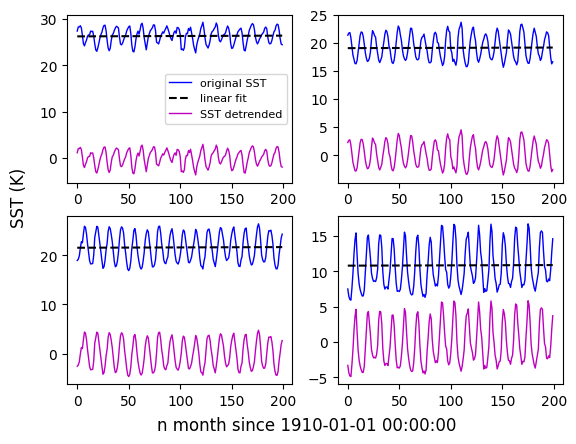

In [10]:
# Find lats, lons in the dataset that are closest to a few chosen values.
testpoints = sst.sel(lat=[0, -30, 30, 45], lon=[0, 90, 190, 220], method='nearest')
lat_testpoints = testpoints['lat'].data
lon_testpoints = testpoints['lon'].data


# Plot before, after, and detrend fit for first 200 timestamps:
n_ts = 200

fig1, axes1 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes1.flatten(), lat_testpoints, lon_testpoints):
    ax.plot(sst.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'b-', linewidth=1, label='original SST')
    ax.plot(fit.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'k--', label='linear fit')
    ax.plot(sst_detrend.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'm-', linewidth=1, label='SST detrended')

fig1.text(0.5, 0.025, "n month since " + str(sst['time'].data[0]), ha='center', va='center', fontsize=12)
fig1.text(0.05, 0.5, "SST (K)", ha='center', va='center', fontsize=12, rotation=90)
axes1[0,0].legend(fontsize=8)

## 2.3 Remove Seasonal Cycle

**Computation**

In [11]:
# Very easy to remove a daily/monthly/yearly/etc cycle using Xarray built-in function:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")
sst_nocycle = sst_detrend.groupby("time.month") - seasonal_cycle

**Create some confirmation plots at same test points as in Section 2.1**

Text(0.05, 0.5, 'SST (K)')

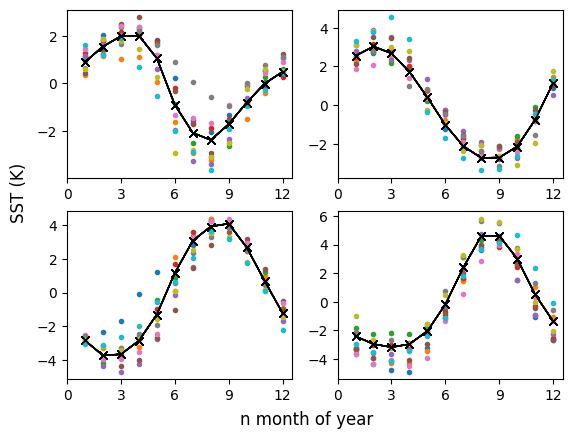

In [12]:
# Mean seasonal cycle overlaid on data for first 10 years:
fig2, axes2 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes2.flatten(), lat_testpoints, lon_testpoints):
    for i in np.arange(1,11):
        ax.plot(seasonal_cycle['month'], sst_detrend.isel(time=range(12*(i-1), 12*i)).sel(lat=lat, lon=lon), '.')
        ax.plot(seasonal_cycle['month'], seasonal_cycle.sel(lat=lat, lon=lon), 'kx-', linewidth=1)

xticks = [0, 3, 6, 9, 12]
for ax in axes2.flatten():
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(xt) for xt in xticks])
fig2.text(0.5, 0.025, "n month of year", ha='center', va='center', fontsize=12)
fig2.text(0.05, 0.5, "SST (K)", ha='center', va='center', fontsize=12, rotation=90)

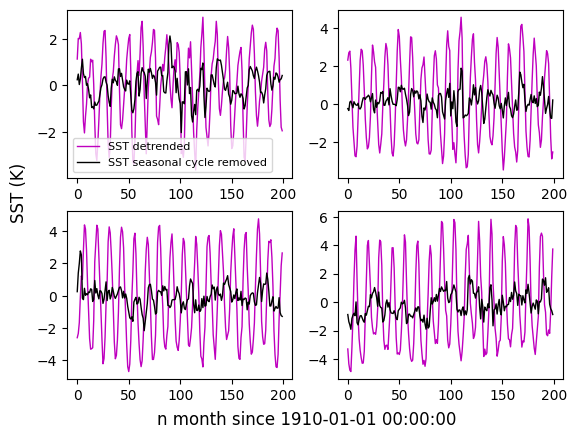

In [13]:
# Plot before and after cycle removal, for first 200 timestamps:
fig3, axes3 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes3.flatten(), lat_testpoints, lon_testpoints):
    ax.plot(sst_detrend.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'm-', linewidth=1, label='SST detrended')
    ax.plot(sst_nocycle.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'k-', linewidth=1, label='SST seasonal cycle removed')

fig3.text(0.5, 0.025, "n month since " + str(sst['time'].data[0]), ha='center', va='center', fontsize=12)
fig3.text(0.05, 0.5, "SST (K)", ha='center', va='center', fontsize=12, rotation=90)
axes3[0,0].legend(fontsize=8)

# 3. Variance and EOF analysis

## 3.1 Variance map

Plot a variance map as a sanity check.

In [14]:
sstvar = sst_nocycle.var(dim=['time'], skipna=True)

/opt/coiled/env/lib/python3.11/site-packages/xarray/core/nputils.py:183: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 1.0, 'Variance of SST anomalies')

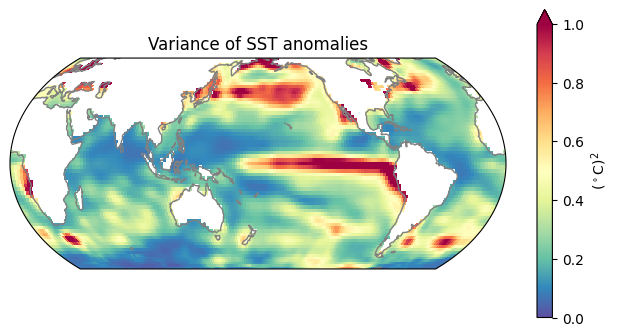

In [15]:
proj = EqualEarth(central_longitude=180)
figvar = plt.figure(figsize=(8, 4))
axvar = plt.axes(projection=proj)


sstvar.plot(
    vmin=0, vmax=1, # vmax of 1 used since there are a few points with anomolously high values.
    transform=PlateCarree(), 
    cmap='Spectral_r', cbar_kwargs={'label': "("+r"$^\circ$"+"C)$^2$"}
    )
axvar.coastlines(color='.5')
axvar.set_title("Variance of SST anomalies", fontsize=12)

In [16]:
sst_nocycle = sst_nocycle.where(sstvar < 2, drop=False) # Remove a few points with anomolously high variances.

## 3.2 Fit EOF model and compute PCs, EOFs, and explained variances
We fit the EOF model and compute explain variance ratios, PC's (or as `xeofs` calls them "scores"), and EOF's (`xeofs` calls them "components").

#### **Model fit**

In [17]:
wgts = np.cos(np.deg2rad(sst_nocycle['lat']))**0.5 # Common practice to weight by latitude

In [18]:
model = xe.models.EOF(
    n_modes=6,
    use_weights=True,
    standardize=False
    )
model.fit(sst_nocycle, dim='time', weights=wgts)

#### **Compute PCs (scores), EOFs (components), and explained variances**

In [19]:
expvar = model.explained_variance_ratio()
expvar.values

array([0.15566093, 0.04830667, 0.03850468, 0.0346849 , 0.03283792,
       0.02758786])

In [20]:
# PC's ("scores"):
# The package automatically normalizes the returned PC's. We back out the raw PC's as well (following https://github.com/nicrie/xeofs/issues/81):
scores_normed = model.scores()
svals = model.singular_values()
scores = scores_normed * svals

In [21]:
# EOFs ("components"):
components = model.components()

#### **Rescale PCs and EOFs to match publication**

Since *mode=EOF\*PC*, we can divide a factor of *c* from *PC* if we multiply *EOF* by that same *c*. We do this here so that our amplitudes resemble those of Messie and Chavez (2011). Turns out we get the right scaling if *c=50* for mode 1 and *c=25* for the remaining modes.

In [22]:
components_scaled = xr.where(components['mode']==1, components*50, components*25)
scores_scaled = xr.where(scores['mode']==1, scores/50, scores/25)

## 3.3 Plot EOFs and PC's

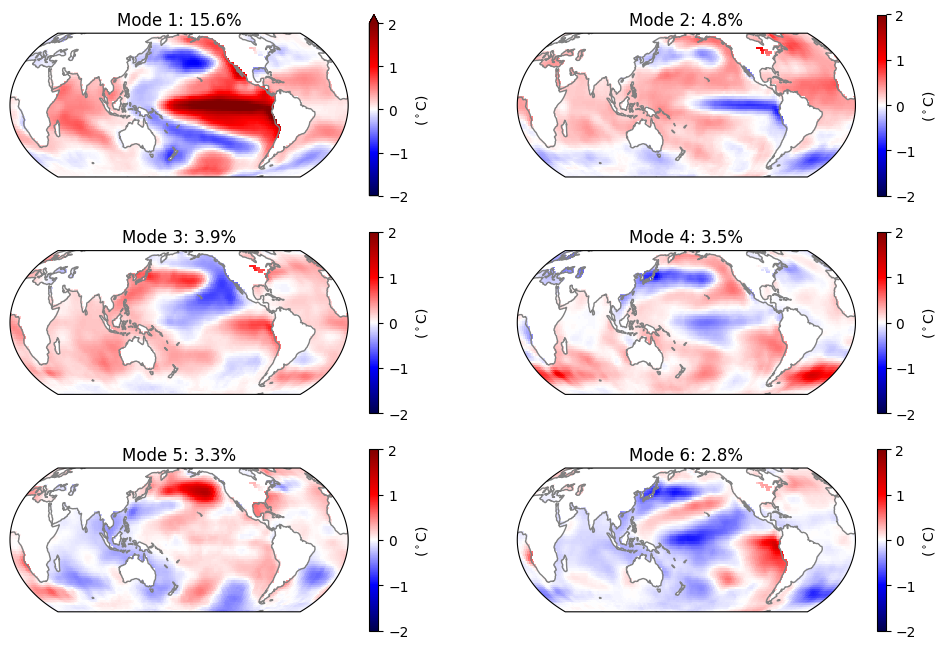

In [23]:
## EOFs

fig4 = plt.figure(figsize=(12, 8))
axes4 = []
proj = EqualEarth(central_longitude=180)
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))


for ax in axes4:
    ax.coastlines(color='.5')


for i, ax in zip(range(1,7), axes4):
    components_scaled.sel(mode=i).plot(
        ax=ax, vmin=-2, vmax=2, add_labels=False,
        transform=PlateCarree(), 
        cmap='seismic', cbar_kwargs={'label': "("+r"$^\circ$"+"C)"}
        
        )
    ax.set_title("Mode "+str(i)+": "+str(round(expvar.values[i-1]*100, 1))+"%", fontsize=12)

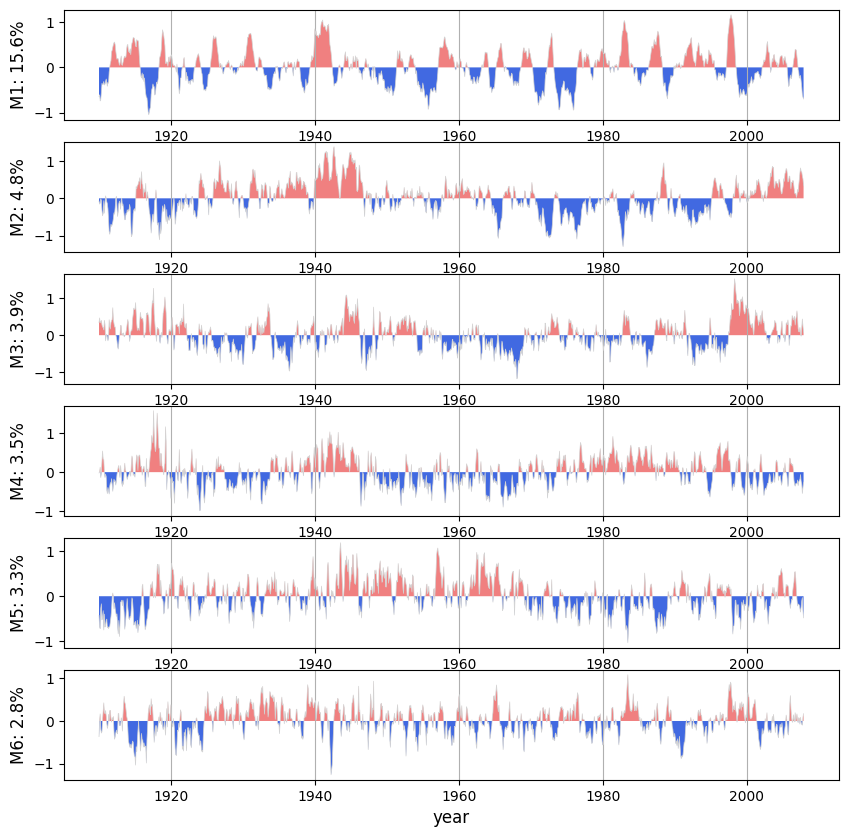

In [24]:
## PC's

# The format of the ERSST timestamps cannot be read by matplotlib without additional packages.
# Instead, convert them to numpy.datetime64:
timestamps_np = [np.datetime64(str(t)) for t in sst['time'].data]

fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))

zeroline = np.zeros(len(timestamps_np)) # For use with matplotlib's fill_between()
for i, ax in zip(range(1, 7), axes5):
    scores_i = scores_scaled.sel(mode=i).values
    pos_score = scores_i > 0
    ax.fill_between(timestamps_np, scores_i, zeroline, where=pos_score, facecolor='lightcoral', interpolate=True)
    ax.fill_between(timestamps_np, scores_i, zeroline, where=~pos_score, facecolor='royalblue', interpolate=True)
    ax.plot(timestamps_np, scores_i, color='lightgrey', linewidth=0.5)
    
    ax.grid(axis='x')
    ax.set_xlabel("year", fontsize=12)
    ax.set_ylabel("M"+str(i)+": "+str(round(expvar.values[i-1]*100, 1))+"%", fontsize=12)

# Brief discussion

Our results are similar but not identical to those of Messie and Chavez (2011). We find the first 6 modes explain 33.8\% of the SST variance, in comparison to their 38.1\%. Our modes 1 and 2 and their corresponding PC's are similar to theirs (their Figures 4 and 5), the first clearly being ENSO. Our EOF 3 has the same spatial pattern if inverted (multiplied by -1). Our mode 5 (both EOF and PC) resembles their mode 4 and our EOF 6 resembles their EOF 5 multiplied by -1 (the PC is harder to compare). The exchange of the order of the modes is not unreasonable since each mode from 4 onward explains less than 4\% of the variance and with a difference of less than 1.2\% explained variance between them. One reason for the differences could be dataset versions: Messie and Chavez (2011) use version 3b of the dataset while we use v5 (some of the updates to v5 can be found at https://doi.org/10.5067/ERSST-L4N50).